# Intro: A Random Search Monte Carlo Hyperarameter Optimization Method

In this notebook we will go through a random search hyperparameter optimization method using a small fraction of the training dataset. We will show that repeatedly sampling from the training set and using those samples to find the optimal hyperparameters is producing very similar results with using the entire training set. The benefits of using only a small sample size as opposed to the entire training set is time and resources: from hours or days to minutes.

We will apply this method to a classification problem.

We will be using XGBoost as our classification algorithm.

In [1]:
# import working libraries
import numpy as np
import pandas as pd

### Data cleaning

For this notebook we will use the Telco Customer Churn dataset from Kaggle: https://www.kaggle.com/blastchar/telco-customer-churn

In [2]:
# read the data
path = 'WA_Fn-UseC_-Telco-Customer-Churn.csv'
data = pd.read_csv(path, squeeze=True)

# inspect the data
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


With a few exceptions, data is categorical in nature. We will convert it to numerical using one-hot-encoding. First, we will remove the customerID column since it's a customer identifier, not a predictor.

In [3]:
# drop customerID column
data = data.drop(columns=['customerID'])
data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Convert the categorical data to one-hot-encoded data

In [4]:
# specify the categorical columns to be converted
to_dummies = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'Churn']

# convert the specified columns using get_dummies
data = pd.get_dummies(data = data, columns = to_dummies)

# inspect the data
data.head()

,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,Dependents_No,...,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_No,Churn_Yes
0,1,29.85,29.85,1,0,1,0,0,1,1,...,0,0,0,1,0,0,1,0,1,0
1,34,56.95,1889.5,0,1,1,0,1,0,1,...,1,0,1,0,0,0,0,1,1,0
2,2,53.85,108.15,0,1,1,0,1,0,1,...,0,0,0,1,0,0,0,1,0,1
3,45,42.30,1840.75,0,1,1,0,1,0,1,...,1,0,1,0,1,0,0,0,1,0
4,2,70.70,151.65,1,0,1,0,1,0,1,...,0,0,0,1,0,0,1,0,0,1


We can see that the targeted data was converted successfully to binary labels. On further inspection we notice columns like 'gender_Female' and 'gender_Male'. They are the exact opposites of each other and will not add useful information. We'll proceed by removing all columns with similar characteristics.

In [5]:
data = data.drop(columns = ['gender_Male', 'SeniorCitizen_0', 'Partner_No', 'Dependents_No', 
       'PhoneService_No','MultipleLines_No', 'OnlineSecurity_No',
       'OnlineBackup_No', 'DeviceProtection_No', 'TechSupport_No', 'StreamingTV_No',
       'StreamingMovies_No', 'PaperlessBilling_No', 'Churn_No'])
data.head()

,tenure,MonthlyCharges,TotalCharges,gender_Female,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
0,1,29.85,29.85,1,0,1,0,0,1,0,...,0,1,0,0,1,0,0,1,0,0
1,34,56.95,1889.5,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
2,2,53.85,108.15,0,0,0,0,1,0,0,...,0,1,0,0,1,0,0,0,1,1
3,45,42.30,1840.75,0,0,0,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0
4,2,70.70,151.65,1,0,0,0,1,0,0,...,0,1,0,0,1,0,0,1,0,1


There is one more thing that needs attention: empty string spaces, which are not NANs. They interfere in trying to fit our data and need to be removed

In [6]:
# dataset has some empty string spaces (not nans) that need to be removed
print('Data shape (rows, cols): ',data.shape)
data.replace(' ', np.nan, inplace=True)
data = data.dropna()
print('NANs removed data shape (rows, cols): ',data.shape)

Data shape (rows, cols):  (7043, 34)
NANs removed data shape (rows, cols):  (7032, 34)


With this, the data cleaning part is complete.

### Predictors and labels

In [7]:
# separate the data into predictors and labels
predictors = data.iloc[:,:-1] # we don't need the column Churn_No, is the inverse of Churn_yes
labels = data.iloc[:,-1]

x0 = predictors.values
y0 = labels.values

### Visualize data

First, we want to assess the balance between the two classes of labels. If, on the one hand, the sets are balanced, accuracy is a good scoring metric. Otherwise AUC (area under curve) will be a better metric to measure the performance of the classifier

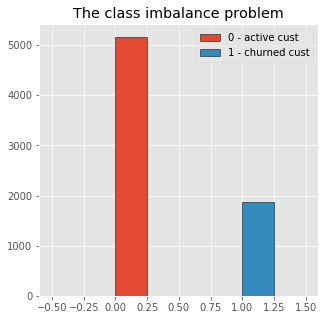

In [8]:
# import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# plot the histogram
fig = plt.figure(figsize=(5,5))
plt.hist(y0[y0 == 0], label = '0 - active cust', edgecolor = 'k', width = .25)
plt.hist(y0[y0 == 1], label = '1 - churned cust', edgecolor = 'k', width = .25)
plt.legend()
plt.title('The class imbalance problem')
plt.show()

Now that we established the imbalanced nature of the dataset, we want to form an idea of the class distribution of the data points. Since the dataset is multidimensional, we will first perfom a dimensionality reduction using PCA and then render the class distribution of the reduced data points

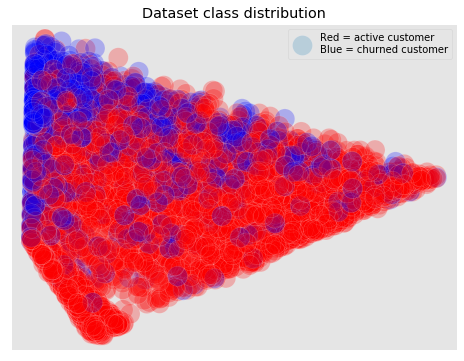

In [9]:
# import the libraries
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap


cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

# reduce dimensions
pca = PCA(n_components = 2)
pca = pca.fit_transform(x0)

# scatterplot
fig = plt.figure(figsize=(8,6))
plt.scatter(pca[:,0], pca[:,1], alpha = .25, edgecolor = 'w', c = y0, s=400, cmap=cm_bright, label = 'Red = active customer\nBlue = churned customer')

plt.title('Dataset class distribution')
plt.xticks([])
plt.yticks([])
plt.legend()
plt.show()

### Data modeling

We're ready to model the data. For this, we'll first split it into a training and a testing set

In [10]:
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(x0,y0, test_size = .35, random_state = 42)
  
features = X_train
labels = y_train
test_features = X_test
test_labels= y_test

Next, we'll run the classifier on the training data using the default settings and score the model performance in order to establish a baseline

In [11]:
# Model with default hyperparameters
import xgboost as xgb
model = xgb.XGBClassifier()

from sklearn.metrics import roc_auc_score
from timeit import default_timer as timer

start = timer()
model.fit(features, labels)
train_time = timer() - start

predictions = model.predict_proba(test_features)[:, 1]
auc_baseline = roc_auc_score(test_labels, predictions)

print('The baseline AUC score on the test set for XGBClassifier is %.5f'%auc_baseline)
print('The baseline training time for XGBClassifier is %.3f seconds'%train_time)

The baseline AUC score on the test set for XGBClassifier is 0.84182
The baseline training time for XGBClassifier is 0.887 seconds


Having established a baseline performance, we'll now see if we can do at least as good or hopefully better by modifying the default values for the hyperparameters. 

Finding better, more optimal values for the hyperparameters is done by either using an exhaustive grid search (very resource intensive), a random grid search, or a Bayesian grid search. The advantages of a Bayesian grid search over a random grid search materialize themselves in the scenario where the scores show at least a statistical significant difference for different hyperparameter values because they will converge faster to that solution than a random search.

Let's take a look at the default values for the classifier

In [12]:
model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

Next we'll create a hyperparameter grid that will be searched for optimal values using a dictionary comprehension

In [13]:
# Hyperparameter grid 

param_grid = {
    'booster': ['gbtree', 'gblinear', 'dart'],
    'base_score': list(np.arange(.1, .9, .1)),
    'gamma': [0, 50, 1000],
    'learning_rate': list(np.logspace(np.log(0.005), np.log(0.2), base = np.exp(1), num = 1000)),
    'max_depth': [3,7,10],
    'n_estimators': list(np.arange(50,250, 10)),
    'max_delta_step': [0,.5,1],
    'reg_lambda': list(np.linspace(0.5, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10))
}

We'll sample from the hyperparameter domain and run our classifier with the sampled values. We'll compare the new scores with the baseline values and see if we detect statistically significant differences or ideally measurable effect sizes.

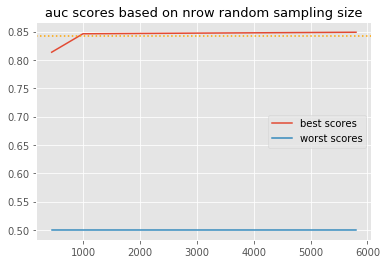

In [14]:
# SAMPLING FROM HYPERPARAMETER DOMAIN

from sklearn.utils import shuffle
import random

trials = 100
nrows = [450, 1000, 5800]

h_params_best = []
h_params_worst = []

best_scores = []
worst_scores = []
n_rows = []

best_distrib = []
worst_distrib = []

for i in nrows:
    
    n_rows.append(i)
    
    auc_rnd = []
    times_rnd = []
    params_rnd = []
    n_samples = []
    auc_distrib = []
    
    
    for n in range(1, trials):
    
        start = timer()
        n_samples.append(n)
        
        # Randomly sample parameters from param domain
        params_rnd_sample = {key: random.sample(value, 1)[0] for key, value in param_grid.items()}
        params_rnd.append(params_rnd_sample)

        # Make a copy of the data ran in the baseline model
        train_rnd = features
        test_rnd = test_features
        train_labels_rnd = labels 
        test_labels_rnd = test_labels

        # Shuffle the training data - this is about randomly selecting training data 
        train_rnd, train_labels_rnd = shuffle(train_rnd, train_labels_rnd)

        # Train predictors and labes
        features_rnd = np.array(train_rnd)
        labels_rnd = train_labels_rnd

        # Test features
        test_features_rnd = np.array(test_rnd)

        # trim the training set to nrows of data
        train_set_rnd = xgb.DMatrix(features_rnd[:i, :], labels_rnd[: i])

        r = xgb.cv(params_rnd_sample, train_set_rnd, num_boost_round = 10000, nfold = 10, metrics = 'auc', 
                   early_stopping_rounds = 10, verbose_eval = False, seed = 50)
       

        # Max AUCscore
        r_best_rnd = np.max(r['test-auc-mean'])
        auc_rnd.append(r_best_rnd)
        
        # Entire distribution
        rnd_distrib = r['test-auc-mean']
        auc_distrib.append(rnd_distrib)


        end = timer() - start
        times_rnd.append(end)


    best_score = np.array(auc_rnd).max()
    best_scores.append(best_score)
    #print(best_score)
    
    best_dist = auc_distrib[np.argmax(best_score)]
    best_distrib.append(best_dist)

    worst_score = np.array(auc_rnd).min()
    worst_scores.append(worst_score)
    #print(worst_score)
    
    worst_dist = auc_distrib[np.argmax(worst_score)]
    worst_distrib.append(worst_dist)

    # best score index
    best_score_index = np.argmax(auc_rnd)

    # worst score index
    worst_score_index = np.argmin(auc_rnd)

    # best hyperparameters
    best_hyperparams = params_rnd[best_score_index]
    h_params_best.append(best_hyperparams)
    #print('\nBest hyperparameters:\n',best_hyperparams)

    # worst hyperparameters
    worst_hyperparameters = params_rnd[worst_score_index]
    h_params_worst.append(worst_hyperparameters)
    #print('\n\n\nWorst hyperparameters:\n',worst_hyperparameters)
    
plt.plot(n_rows, best_scores, label='best scores')
plt.plot(n_rows, worst_scores, label='worst scores')
plt.axhline(auc_baseline, linestyle = ':', color = 'orange')
plt.title('auc scores based on nrow random sampling size', fontsize = 13)
plt.legend()


From the plot of best and worst scores across different training dataset sizes we notice the large variance between the min and max scores irrespective of dataset size, which signals that point estimates are not a good representation of model performance. 

If we want a more accurate representation of how the model will perform we'll need interval estimates. For this purpose, we need to run cross validation on the training data.

We'll restate the baseline performance with the default hyperparameters

In [ ]:
N_FOLDS = 10
# baseline cv model performance
baseline_params = model.get_xgb_params()
train_set_baseline = xgb.DMatrix(features, labels)

r = xgb.cv(baseline_params, train_set_baseline, num_boost_round = 10000, nfold = N_FOLDS, metrics = 'auc', 
               early_stopping_rounds = 10, verbose_eval = False, seed = 50)
#print(r)
auc_cv = np.mean(r['test-auc-mean'])
auc_cv_std = r['test-auc-mean'].std()

Now we will use the worst of the best hyperparameters and the best of the worst hyperparameters and run a cross-validation with those values because the cross validation is a better measure of the mean classifier performance, being an average performance score

In [ ]:
# lower-best score index
lower_best_score_index = np.argmin(best_scores)

# upper-best score index
upper_best_score_index = np.argmax(best_scores)

# worst-best hyper parameter set
lower_best_hyperparams = h_params_best[lower_best_score_index]

# best-worst hyper parameter set
upper_best_hyperparams = h_params_best[upper_best_score_index]

# run the initial data - the data used to compute the baseline score - with the new values
r_b = xgb.cv(lower_best_hyperparams, train_set_baseline, num_boost_round = 10000, nfold = N_FOLDS, metrics = 'auc', 
                   early_stopping_rounds = 10, verbose_eval = False, seed = 50)

r_w = xgb.cv(upper_best_hyperparams, train_set_baseline, num_boost_round = 10000, nfold = N_FOLDS, metrics = 'auc', 
                   early_stopping_rounds = 10, verbose_eval = False, seed = 50)

auc_lower_best_hyper = np.mean(r_b['test-auc-mean'])
auc_upper_best_hyper = np.mean(r_w['test-auc-mean'])

auc_lower_std = r_b['test-auc-mean'].std()
auc_upper_std = r_w['test-auc-mean'].std()

#print('The baseline AUC score on the test set for XGBClassifier is %.5f'%auc_baseline)
print('The baseline mean cross-validation AUC score on the test set for XGBClassifier is %.5f'%auc_cv)
print('The lower end of the mean AUC scores on the test set for XGBClassifier is %.5f'%auc_lower_best_hyper)
print('The upper end of the mean AUC scores on the test set for XGBClassifier is %.5f'%auc_upper_best_hyper)

plt.figure(figsize=(8,5))
plt.axvline(r_b['test-auc-mean'].mean(), linestyle=':', label = 'upper-best auc mean score', color='g')
plt.axvline(r_w['test-auc-mean'].mean(), linestyle=':', label = 'lower-best mean auc score', color='brown')
#plt.axvline(auc_baseline, linestyle=':', label = 'default hyperparameter auc score no cv')
plt.axvline(auc_cv, linestyle=':', label = 'default mean auc score with cv', color='k')

plt.hist(r_b['test-auc-mean'], alpha = .5, edgecolor='k', label='lower best mean scores')
plt.hist(r_w['test-auc-mean'], alpha = .5, edgecolor='k', label='upper best mean scores')
plt.hist(r['test-auc-mean'], alpha = .5, edgecolor='k', label='baseline cv mean scores')


plt.xticks([.83,.85,])
plt.legend()
plt.title('AUC scores distribution comparison')
plt.show()

### Practical significance

#### Are the score differences practically significant?

It depends on the problem being tackled. Yet, despite the *yes, but*, what's undeniable is that the results are extremelly similar. Do you have time and resources to burn? Go for it. But if you're in need of a *good enough* result *now*, trim the training set. You won't be that far from the truth.